# Final Classification Model

In [65]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [47]:
macro = pd.read_csv('macro.csv').iloc[:,1:-1]
target = pd.read_csv('macro.csv').iloc[:,-1]

In [45]:
lda = pd.read_csv('df_with_lda.csv').iloc[:,-6:]

In [55]:
sentiments = pd.read_csv('sentiments.csv').iloc[1:,:].reset_index().drop(columns=['index'])

In [48]:
macro.head()

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
0,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429
1,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355
2,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333
3,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323
4,15302.705,201.8,4.6,136325.0,177343.0,8420042.0,16.779000,4.991000


In [49]:
target.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [46]:
lda.head()

,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6
0,2.532629e-07,0.442418,0.098614,0.148826,0.021148,0.288993
1,5.791823e-07,0.013136,0.000042,0.970716,0.002117,0.013989
2,2.570856e-07,0.388304,0.011189,0.465910,0.011551,0.123046
3,2.403132e-07,0.492659,0.050694,0.115820,0.125781,0.215045
4,1.027025e-06,0.005665,0.000001,0.992321,0.000148,0.001864


In [56]:
sentiments.head()

,sentiments
0,-0.1
1,0.0
2,0.0
3,0.0
4,0.6


In [69]:
final_df = pd.concat([macro, lda, sentiments, target], axis=1).reindex(macro.index)

In [70]:
final_df

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments,target
0,15267.026,199.400,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,2.532629e-07,0.442418,0.098614,0.148826,0.021148,2.889927e-01,-0.1,1
1,15267.026,199.700,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,5.791823e-07,0.013136,0.000042,0.970716,0.002117,1.398868e-02,0.0,1
2,15302.705,200.700,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,2.570856e-07,0.388304,0.011189,0.465910,0.011551,1.230458e-01,0.0,1
3,15302.705,201.300,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,2.403132e-07,0.492659,0.050694,0.115820,0.125781,2.150454e-01,0.0,1
4,15302.705,201.800,4.6,136325.0,177343.0,8420042.0,16.779000,4.991000,1.027025e-06,0.005665,0.000001,0.992321,0.000148,1.864488e-03,0.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,18794.426,260.462,6.9,142545.0,212005.0,27747798.0,29.059677,0.090000,8.155466e-07,0.001263,0.277596,0.718868,0.000778,1.493741e-03,0.1,0
177,18794.426,260.927,6.7,142809.0,208966.0,27747798.0,24.806000,0.086333,7.587675e-07,0.001052,0.233172,0.763330,0.000944,1.501466e-03,0.1,0
178,18794.426,261.560,6.7,142503.0,205818.0,27747798.0,22.198710,0.090000,8.281763e-07,0.000082,0.501833,0.497920,0.000163,8.281763e-07,0.1,0
179,18794.426,262.231,6.3,142669.0,220845.0,27747798.0,24.763871,0.085161,1.981140e-06,0.000002,0.000002,0.999990,0.000002,1.981140e-06,0.3,0


### Stacking

In [71]:
train_size = int(len(final_df) * 0.7)
train, test = final_df[0:train_size], final_df[train_size:len(final_df)]
print('Observations: %d' % (len(final_df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 181
Training Observations: 126
Testing Observations: 55


In [269]:
X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]
y_train = train.target
y_test = test.target

In [73]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_norm = (X_train - X_train_mean)/X_train_std
X_test_norm = (X_test - X_train_mean)/X_train_std

In [74]:
X_train_norm.describe()

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments
count,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02
mean,1.061585e-14,-1.367513e-15,-2.164054e-15,2.918301e-15,9.357594e-16,7.049035e-18,2.202823e-16,-1.233581e-16,1.409807e-17,-2.273314e-16,-1.257812e-16,-3.876969e-17,-2.564087e-16,-2.308559e-16,-1.762259e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.274902e+00,-1.948426e+00,-1.313045e+00,-1.613832e+00,-2.107143e+00,-1.535712e+00,-1.017516e+00,-5.959379e-01,-4.598352e-01,-5.517964e-01,-8.375222e-01,-8.492882e-01,-3.215702e-01,-6.576107e-01,-2.499406e+00
25%,-7.907541e-01,-8.031639e-01,-9.946797e-01,-8.833009e-01,-5.734172e-01,-1.036391e+00,-6.463026e-01,-5.725120e-01,-4.139597e-01,-5.445820e-01,-8.291750e-01,-8.318972e-01,-3.215327e-01,-6.491820e-01,-6.894912e-01
50%,-3.889498e-01,1.264102e-01,-9.264587e-02,8.956371e-02,1.964664e-01,1.005970e-01,-3.092352e-01,-5.488121e-01,-3.608710e-01,-5.057229e-01,-5.583229e-01,-6.180862e-01,-2.981342e-01,-5.906540e-01,-8.618640e-02
75%,6.379854e-01,9.642093e-01,9.553052e-01,5.507161e-01,4.792275e-01,8.713676e-01,3.129302e-01,2.059479e-01,1.379887e-01,-1.893318e-01,8.482341e-01,1.354534e+00,-1.797519e-01,2.729914e-01,5.171184e-01
max,2.119144e+00,1.432838e+00,1.658361e+00,2.124056e+00,1.684213e+00,1.533715e+00,4.516257e+00,2.117231e+00,6.999801e+00,3.094864e+00,1.821035e+00,1.459208e+00,6.595048e+00,3.751794e+00,3.533643e+00


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

In [326]:
def cal_vif(x):
    thresh = 5
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1, k):
        print('Iteration no ', i)
        print(vif)
        a = np.argmax(vif)
        print('Max vif ', a)
        if vif[a] <= thresh:
            break
        if i == 1:
            output = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return output

x = pd.DataFrame(X_train_norm)
selected_features = cal_vif(x)
selected_features.head()

Iteration no  1
[90.68963078004354, 41.83842849602714, 95.18602330100406, 94.47896070537455, 55.46245587145537, 62.696002341960615, 3.1765934108137728, 41.67384198987408, 2488.0871599810243, 84179432287298.98, 166799986198907.25, 225179981368524.8, 7778237698394.639, 59650326190337.695, 1.1438890160667734]
Max vif  11
Iteration no  2
[89.61544095049483, 41.762514753796566, 93.47466583387033, 94.46331092324097, 55.403458682010054, 62.69168117072353, 3.163421854182282, 40.65693136134039, 1.494150323145746, 2.084774403858053, 2.1300327278686244, 1.1625055872340733, 1.5298251646974554, 1.1388614999778393]
Max vif  3
Iteration no  3
[51.33602206925491, 37.41771502072303, 26.530678115346557, 46.307891909425585, 61.858061665912075, 2.9676707126971946, 40.20592630738528, 1.47312185340926, 2.061746631237053, 2.1187238752665176, 1.157214819633932, 1.5188233590334097, 1.0786378906853349]
Max vif  4
Iteration no  4
[35.10080410951239, 35.849980473666236, 18.784963391134035, 42.288795219860106, 2.9

,GDPC1,UNRATE,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_5,prob_topic_6,sentiments
0,-1.103399,-1.100801,-0.840487,-0.407507,1.119808,-0.574050,-0.058876,0.637844,-0.689491
1,-1.103399,-1.153862,-0.915065,-0.181225,-0.502167,-0.837411,-0.295280,-0.594907,-0.086186
2,-1.057360,-1.153862,-0.899308,-0.404853,0.915345,-0.807628,-0.178089,-0.106040,-0.086186
3,-1.057360,-1.206923,-0.626542,-0.416498,1.309635,-0.702080,1.240864,0.306363,-0.086186
4,-1.057360,-1.206923,-0.373138,0.129707,-0.530395,-0.837521,-0.319741,-0.649255,3.533643


In [344]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def cal_vif(x):
    thresh = 4
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1, k):
        print('Iteration no ', i)
        print(vif)
        a = np.argmax(vif)
        print('Max vif ', a)
        if vif[a] <= thresh:
            break
        if i == 1:
            output = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return output

x = pd.DataFrame(X_train_norm)
selected_features = cal_vif(x)
selected_features.head()

Iteration no  1
[90.68963078004354, 41.83842849602714, 95.18602330100406, 94.47896070537455, 55.46245587145537, 62.696002341960615, 3.1765934108137728, 41.67384198987408, 2488.0871599810243, 84179432287298.98, 166799986198907.25, 225179981368524.8, 7778237698394.639, 59650326190337.695, 1.1438890160667734]
Max vif  11
Iteration no  2
[89.61544095049483, 41.762514753796566, 93.47466583387033, 94.46331092324097, 55.403458682010054, 62.69168117072353, 3.163421854182282, 40.65693136134039, 1.494150323145746, 2.084774403858053, 2.1300327278686244, 1.1625055872340733, 1.5298251646974554, 1.1388614999778393]
Max vif  3
Iteration no  3
[51.33602206925491, 37.41771502072303, 26.530678115346557, 46.307891909425585, 61.858061665912075, 2.9676707126971946, 40.20592630738528, 1.47312185340926, 2.061746631237053, 2.1187238752665176, 1.157214819633932, 1.5188233590334097, 1.0786378906853349]
Max vif  4
Iteration no  4
[35.10080410951239, 35.849980473666236, 18.784963391134035, 42.288795219860106, 2.9

,GDPC1,UNRATE,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_5,prob_topic_6,sentiments
0,-1.103399,-1.100801,-0.840487,-0.407507,1.119808,-0.574050,-0.058876,0.637844,-0.689491
1,-1.103399,-1.153862,-0.915065,-0.181225,-0.502167,-0.837411,-0.295280,-0.594907,-0.086186
2,-1.057360,-1.153862,-0.899308,-0.404853,0.915345,-0.807628,-0.178089,-0.106040,-0.086186
3,-1.057360,-1.206923,-0.626542,-0.416498,1.309635,-0.702080,1.240864,0.306363,-0.086186
4,-1.057360,-1.206923,-0.373138,0.129707,-0.530395,-0.837521,-0.319741,-0.649255,3.533643


In [164]:
rf_clf = RandomForestClassifier().fit(X_train_norm, y_train)

In [165]:
rf_clf.feature_importances_

array([0.06005395, 0.06972532, 0.05313757, 0.07049081, 0.06934448,
       0.05271901, 0.0879085 , 0.06661225, 0.06662449, 0.08876962,
       0.08602379, 0.07414888, 0.06887704, 0.05299434, 0.03256994])

In [166]:
importance = rf_clf.feature_importances_

Feature: 0, Score: 0.06005
Feature: 1, Score: 0.06973
Feature: 2, Score: 0.05314
Feature: 3, Score: 0.07049
Feature: 4, Score: 0.06934
Feature: 5, Score: 0.05272
Feature: 6, Score: 0.08791
Feature: 7, Score: 0.06661
Feature: 8, Score: 0.06662
Feature: 9, Score: 0.08877
Feature: 10, Score: 0.08602
Feature: 11, Score: 0.07415
Feature: 12, Score: 0.06888
Feature: 13, Score: 0.05299
Feature: 14, Score: 0.03257


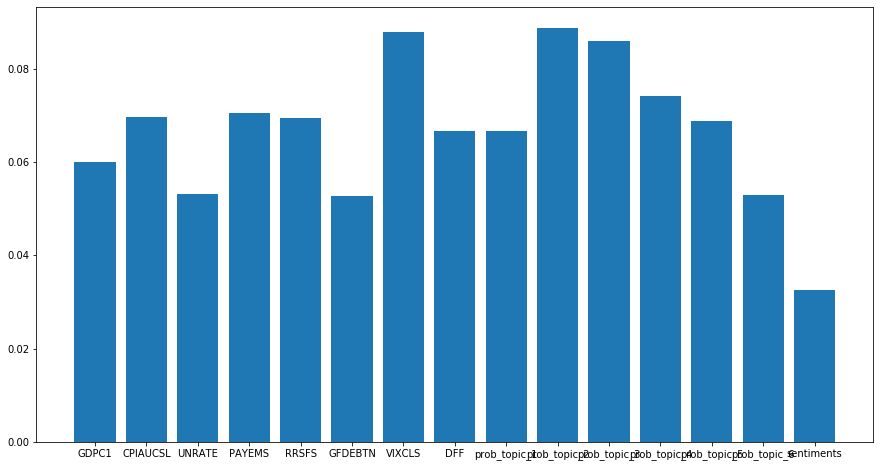

In [175]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(15,8))
plt.bar([final_df.columns[x] for x in range(len(importance))], importance)
plt.show()

In [169]:
from info_gain import info_gain

In [171]:
cols = final_df.iloc[:, :-1].columns
igr_list = []
for col in cols:
    key_value = [col]
    igr = info_gain.info_gain_ratio(
        final_df['target'].values.tolist(), 
        final_df[col].values.tolist())
    key_value.append(igr)
    igr_list.append(key_value)
igr_list = sorted(igr_list, key=lambda x: x[1], reverse=True)

In [172]:
igr_list

[['CPIAUCSL', 0.14289734153473],
 ['RRSFS', 0.1424762725758933],
 ['prob_topic_1', 0.1424762725758933],
 ['prob_topic_2', 0.1424762725758933],
 ['prob_topic_3', 0.1424762725758933],
 ['prob_topic_4', 0.1424762725758933],
 ['prob_topic_5', 0.1424762725758933],
 ['prob_topic_6', 0.1424762725758933],
 ['PAYEMS', 0.14166375728218206],
 ['VIXCLS', 0.14166375728218206],
 ['DFF', 0.14065596890528995],
 ['GDPC1', 0.10108780402805446],
 ['GFDEBTN', 0.09381973062759424],
 ['UNRATE', 0.09050002536674114],
 ['sentiments', 0.027409347810619843]]

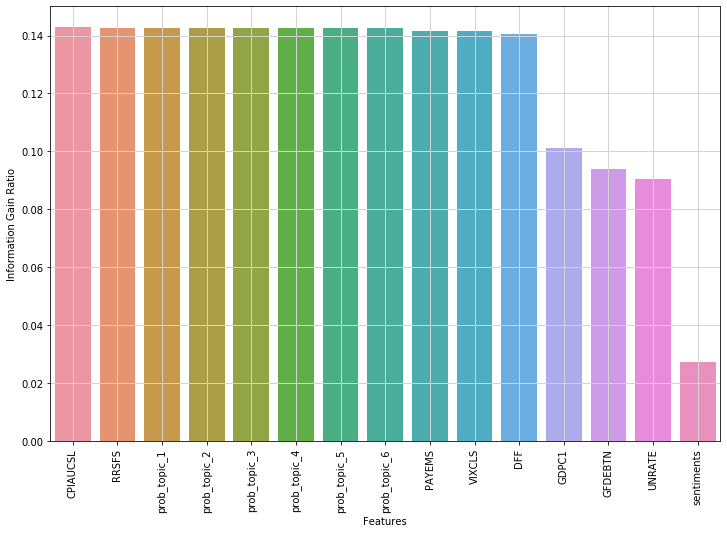

In [173]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Features", 
                 y="Information Gain Ratio", 
                 data=pd.DataFrame(igr_list, 
                                   columns=['Features', 
                                            'Information Gain Ratio']))
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

In [230]:
igr_top_3 = [x[0] for x in igr_list][:3]

In [231]:
vif_top_3 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][:3]

In [232]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_3 = [final_df.columns[x] for x in indices][:3]

In [233]:
final_set = []
for i in igr_top_3:
    if i not in final_set:
        final_set.append(i)
for j in vif_top_3:
    if j not in final_set:
        final_set.append(j)
for k in rf_top_3:
    if k not in final_set:
        final_set.append(k)
final_set

['CPIAUCSL',
 'RRSFS',
 'prob_topic_1',
 'GDPC1',
 'UNRATE',
 'VIXCLS',
 'prob_topic_2',
 'prob_topic_3']

In [237]:
igr_top_1 = [x[0] for x in igr_list][0]

In [238]:
vif_top_1 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][0]

In [239]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_1 = [final_df.columns[x] for x in indices][0]

In [240]:
final_set_1=[igr_top_1, vif_top_1, rf_top_1]

In [279]:
final_set_1

['CPIAUCSL', 'GDPC1', 'prob_topic_2', 'target']

In [252]:
my_set = ['VIXCLS', 'prob_topic_2']
my_set.append('target')
df_fs = final_df[my_set]
X = df_fs.drop(columns=['target'])
y = df_fs.target

In [241]:
final_set_1.append('target')
df_fs = final_df[final_set]
X = df_fs.drop(columns=['target'])
y = df_fs.target

In [234]:
final_set.append('target')
df_fs = final_df[final_set]
X = df_fs.drop(columns=['target'])
y = df_fs.target

In [253]:
results_fs = []
# classifier_name_fs = []
tscv = TimeSeriesSplit(n_splits=5)
all_y_preds = []
all_y_true = []
clf = SVC(random_state=1)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
    y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    all_y_preds.extend(y_preds)
    all_y_true.extend(y_test)
results_fs.append(f1_score(all_y_true,all_y_preds, average='weighted'))
# classifier_name_fs.append(classifier[0])

In [250]:
results_fs

[0.3537441860465116]

In [254]:
results_fs

[0.3537441860465116]

In [264]:
results_fs = []
# classifier_name_fs = []
tscv = TimeSeriesSplit(n_splits=5)
all_y_preds = []
all_y_true = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
    y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    all_y_preds.extend(y_preds)
    all_y_true.extend(y_test)
results_fs.append(f1_score(all_y_true,all_y_preds, average='weighted'))
# classifier_name_fs.append(classifier[0])

In [265]:
results_fs

[0.3193233082706766]

In [356]:
base_learners = [("SVC", SVC(random_state=1)),
                 ("Decision Tree", DecisionTreeClassifier(random_state=1)),
                 ("Logistic Regression", LogisticRegression(random_state=1))]

In [357]:
clf = StackingClassifier(estimators=base_learners, final_estimator=DecisionTreeClassifier(random_state=1))

In [337]:
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(random_state=1))

In [358]:
y_pred = clf.fit(X_train.iloc[:,[0,2,6,8,9,10,12]], y_train).predict(X_test.iloc[:,[0,2,6,8,9,10,12]])

In [338]:
y_pred = clf.fit(X_train.iloc[:,[6,7,8,9,10,12,13,14]], y_train).predict(X_test.iloc[:,[6,7,8,9,10,12,13,14]])

C:\Users\jorda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jorda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [140]:
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [97]:
from sklearn.metrics import classification_report

In [359]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           0       0.44      0.46      0.45        24
           1       0.43      0.57      0.49        23

    accuracy                           0.44        55
   macro avg       0.29      0.34      0.31        55
weighted avg       0.37      0.44      0.40        55



C:\Users\jorda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
